In [165]:
import numpy as np
import pandas as pd
from pyproj import Geod
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import haversine
from math import sin, cos, sqrt, atan2, radians
from scipy import stats

In [166]:
train_data = pd.read_csv( "train.csv" )
test_data = pd.read_csv( "test.csv" )

In [167]:
# Utiliy functions

#Get distance between pairs of lat-lon points
wgs84_geod = Geod(ellps='WGS84')
def get_distance(lat1,lon1,lat2,lon2):
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
    return dist

In [ ]:
# Hypothesis function
def hyp(theta, X):
    return np.dot(X, theta.T)  

# The loss function in our case is the sum of the squared error
def loss_func(theta, X, Y):
    return np.sum(((hyp(theta, X) - Y)**2) / (2 * X.shape[0]))

def get_graident(theta, X, Y):
    derivatives = []
  
    for i in range(0, X.shape[1]):
        derivatives.append(np.sum((hyp(theta, X) - Y) * X[:, i]) / X.shape[0])

    return np.array(derivatives)


def gradient_descent(X, Y, maxniter=20000):
    thetas = np.random.rand(X.shape[1],)
    alpha = 0.01
    costs = []
    
    for i in range(0, maxniter):
        thetas = thetas - (alpha * get_graident(thetas, X, Y))
        costs.append(loss_func(thetas, X, Y))
        
    return thetas, costs

In [168]:
def normalize(data):
    return ((data-data.min())/(data.max()-data.min()))


def process_data(data):
    # Calculating distance (m) based on longitude/latituides and adding it in a new column 'dist'
    data['dist'] = get_distance(data['pickup_latitude'].tolist(), data['pickup_longitude'].tolist(),
                                data['dropoff_latitude'].tolist(), data['dropoff_longitude'].tolist())
    
    data['dist'] = data['dist'] / 1000
    data['haversine_distance'] = data.apply(lambda r: haversine.haversine((r['pickup_latitude'],r['pickup_longitude']),
                                                                          (r['dropoff_latitude'], r['dropoff_longitude'])), 
                                                                          axis=1)
    data['manhattan_distance'] = (abs(data.dropoff_longitude - data.pickup_longitude) +
                                  abs(data.dropoff_latitude - data.pickup_latitude))
    
    data['log_distance'] = np.log(data['dist'] + 1)
    data['log_haversine_distance'] = np.log(data['haversine_distance'] + 1)
    data['log_manhattan_distance'] = np.log(data.manhattan_distance + 1)
    
    data['sqr_distance'] = data['log_distance']**2
    data['sqr_haversine_distance'] = data['log_haversine_distance']**2
    data['sqr_manhattan_distance'] = data['log_manhattan_distance']**2
    
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
    data['pickup_minute_of_the_day'] = data.pickup_datetime.dt.hour*60 + data.pickup_datetime.dt.minute
    data['pickup_month'] = data.pickup_datetime.dt.month
    data['pickup_dayofyear'] = data['pickup_datetime'].dt.dayofyear

    data['no_passengers'] = data.passenger_count.map(lambda x: 1 if x == 0 else 0)
    data['one_passenger'] = data.passenger_count.map(lambda x: 1 if x == 1 else 0)
    data['few_passengers'] = data.passenger_count.map(lambda x: 1 if x > 1 and x <= 4 else 0)
    data['many_passengers'] = data.passenger_count.map(lambda x: 1 if x >= 5 else 0)
    
    data['night_trip'] = [True if x < 7 else False for x in data['pickup_hour']]
    data['rush_hour'] = [True if 9 < x < 20 else False for x in data['pickup_hour']]
    data['weekday'] = [True if x < 5 else False for x in data['pickup_weekday']]
    
    # Replacing N of store_and_fwd_flag with 0 and Y with 1
    data = data.replace({'N': 0, 'Y': 1})
    
    # Dropping columns no longer required
    data = data.drop(['pickup_latitude','pickup_longitude', 'pickup_datetime', 'pickup_weekday', 
                      'dropoff_latitude','dropoff_longitude', 'store_and_fwd_flag', 'id'], axis=1)
     
    return data

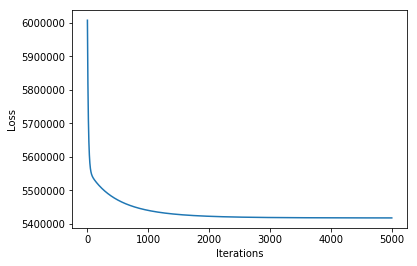

In [169]:
proc_data = process_data(train_data)
X = normalize(proc_data.drop('trip_duration', axis=1)).values
Y = proc_data['trip_duration'].values

max_iters = 5000
thetas, costs = gradient_descent(X, Y, max_iters)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.plot(np.arange(0, max_iters), costs)

In [170]:
pred = hyp(thetas, normalize(process_data(test_data)))
submission = pd.DataFrame({'id':test_data['id'], 'trip_duration':pred})
submission.to_csv("kaggle_submission.csv", index=False)

submission['trip_duration'].describe()

count    30000.000000
mean       986.798618
std        575.141969
min       -224.208717
25%        610.136805
50%        859.003096
75%       1208.636101
max       5250.334123
Name: trip_duration, dtype: float64

In [171]:
# from scipy import stats
# temp = train_data[train_data.trip_duration <= np.percentile(train_data.trip_duration, 99)]

# fig, ax = plt.subplots(2,2,figsize=(20, 10), sharex=False, sharey = False)
# sns.despine(left=True)
# sns.distplot(temp['trip_duration'].values, label = 'pickup_latitude',color="g",bins = 100, ax=ax[0,0])

In [172]:
submission

,id,trip_duration
0,id1430318,974.596935
1,id3276964,580.372193
2,id2541342,1107.068081
3,id3582288,507.592009
4,id2976277,247.036216
5,id1856113,665.417180
6,id0712136,1220.959503
7,id2704634,937.174684
8,id2736446,231.924759
9,id3267520,991.148227
